<a href="https://colab.research.google.com/github/JunyiJ/VAEs/blob/master/VQVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Code largely adopted from https://github.com/zalandoresearch/pytorch-vq-vae and https://github.com/Jackson-Kang/Pytorch-VAE-tutorial

In [2]:
#@title Load Data
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

100%|██████████| 170M/170M [00:11<00:00, 15.0MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
#@title Residual Connection
class Residual(nn.Module):
  def __init__(self, num_hidden, num_residual_hidden):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(num_hidden, num_residual_hidden,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(num_residual_hidden, num_hidden,
                  kernel_size=1, stride=1, padding=0)
        )
  def forward(self, x):
    return x + self.layers(x)

In [4]:
#@title Encoder
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(input_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        Residual(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Conv2d(hidden_dim, output_dim, kernel_size=1)
    )
  def forward(self, x):
    return self.layers(x)

In [5]:
#@title Decoder
class Decoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        Residual(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(hidden_dim, output_dim, kernel_size=4, stride=2, padding=1),
    )

  def forward(self, x):
    return self.layers(x)

In [6]:
#@title Vector Quantization
class VQ(nn.Module):
  def __init__(self, n_emb, emb_dim, commitment_cost=0.25):
    super().__init__()
    self.commitment_cost = commitment_cost
    # K x D where D = C (channel_size)
    self.n_emb = n_emb
    self.emb_dim = emb_dim
    self.embedding = nn.Embedding(n_emb, emb_dim)
    nn.init.uniform_(self.embedding.weight.data, -1.0 / n_emb, 1.0 / n_emb)

  def forward(self, x):
    # convert inputs from B(atch)C(hannel)H(eight)W(eight) -> BHWC
    x = x.permute(0, 2, 3, 1).contiguous()
    x_shape = x.shape
    flat_x = x.view(-1, self.emb_dim)

    # computes the squared Euclidean distance between each input vector
    # and each embedding vector. ||x-y||^2 = ||x||^2 + ||y||^2 - 2x*y
    distances = torch.sum(flat_x**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * flat_x @ self.embedding.weight.T

    # Encoding by finding the cloest embedding
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], self.n_emb, device=x.device)
    # Create a one hot encoding of size num_examples x K (n_emb), where for each row/example, 1 is filled for the cloest embedding index
    encodings.scatter_(1, encoding_indices, 1)

    # quantized = (encodings @ self.embedding.weight).view(x.shape)
    quantized = self.embedding(encoding_indices).view(x.shape)

    e_latent_loss = F.mse_loss(quantized.detach(), x)
    q_latent_loss = F.mse_loss(quantized, x.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    # Straight-Throuogh Estimator (STE): the returned value is equal to quantized but the gradient flow as if it were x to ensure gradient are directly passed to the encoder
    quantized = x + (quantized - x).detach()
    avg_probs = torch.mean(encodings, dim=0)
    # How evenly the embeddings are being utilized: high perplexity implies embeddings are used uniformly
    # Perplexity = e^H(p) Entropy H(p)=-p*log(p)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    x_hat = quantized.permute(0, 3, 1, 2).contiguous()

    return loss, x_hat, perplexity, encodings

In [7]:
#@title Vector Quantization with EMA
class VQEMA(nn.Module):
  def __init__(self, n_emb, emb_dim, commitment_cost, decay, epsilon=1e-5):
    super().__init__()
    self.commitment_cost = commitment_cost
    self.decay = decay
    self.epsilon = epsilon
    # K x D where D = C (channel_size)
    self.n_emb = n_emb
    self.emb_dim = emb_dim
    self.embedding = nn.Embedding(n_emb, emb_dim)
    nn.init.uniform_(self.embedding.weight.data, -1.0 / n_emb, 1.0 / n_emb)
    self.register_buffer('ema_cluster_size', torch.zeros(self.n_emb))
    self.register_buffer('ema_emb', self.embedding.weight.clone())

  def forward(self, x):
    # convert inputs from B(atch)C(hannel)H(eight)W(eight) -> BHWC
    x = x.permute(0, 2, 3, 1).contiguous()
    x_shape = x.shape
    flat_x = x.view(-1, self.emb_dim)

    # computes the squared Euclidean distance between each input vector
    # and each embedding vector. ||x-y||^2 = ||x||^2 + ||y||^2 - 2x*y
    # Tensor of size (BWH, D) @ (K, D). T = (BWH, K)
    distances = torch.sum(flat_x**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * flat_x @ self.embedding.weight.T

    # Encoding by finding the cloest embedding
    # Tensor of shape (BWH, 1)
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], self.n_emb, device=x.device)
    # Create a one hot encoding of size num_examples x K (n_emb), where for each row/example, 1 is filled for the cloest embedding index
    encodings.scatter_(1, encoding_indices, 1)

    quantized = torch.matmul(encodings, self.embedding.weight).view(x.shape)

    e_latent_loss = F.mse_loss(quantized.detach(), x)
    q_latent_loss = F.mse_loss(quantized, x.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    # Straight-Throuogh Estimator (STE): the returned value is equal to quantized but the gradient flow as if it were x to ensure gradient are directly passed to the encoder
    quantized = x + (quantized - x).detach()
    if self.training:
      with torch.no_grad():
        self.ema_cluster_size = self.ema_cluster_size * self.decay + (1 - self.decay) * torch.sum(encodings, 0)
        # Normalize
        n = torch.sum(self.ema_cluster_size)
        self.ema_cluster_size = n * (self.ema_cluster_size + self.epsilon) / (n + self.n_emb * self.epsilon)
        # (B*W*H, K).T @ (B*W*H, D) = (K, D)
        dw = encodings.t() @ flat_x
        # ema_emb of tensor shape (K, D)
        self.ema_emb = self.ema_emb * self.decay + dw * (1 - self.decay)
        self.embedding.weight.data = self.ema_emb / self.ema_cluster_size.unsqueeze(1)



    avg_probs = torch.mean(encodings, dim=0)
    # How evenly the embeddings are being utilized: high perplexity implies embeddings are used uniformly
    # Perplexity = e^H(p) Entropy H(p)=-p*log(p)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    x_hat = quantized.permute(0, 3, 1, 2).contiguous()

    return loss, x_hat, perplexity, encodings

In [8]:
#@title Model
class Model(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_emb, emb_dim, commitment_cost, decay=0):
    super().__init__()
    self.encoder = Encoder(input_dim, hidden_dim, emb_dim)
    self.vq = VQ(num_emb, emb_dim, commitment_cost)
    if decay != 0:
      self.vq = VQEMA(num_emb, emb_dim, commitment_cost, decay)

    self.decoder = Decoder(emb_dim, hidden_dim, output_dim)

  def forward(self, x):
    z = self.encoder(x)
    loss, quantized, perplexity, encodings = self.vq(z)
    x_recon = self.decoder(quantized)
    return loss, x_recon, perplexity

In [9]:

data_variance = np.var(training_data.data / 255.0)
data_variance

0.06328692405746414

In [10]:
#@title Train model
batch_size = 256
epochs  = 50
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

input_dim = 3
output_dim = 3
num_hiddens = 512
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-4

model = Model(input_dim, num_hiddens, output_dim, num_embeddings, embedding_dim, commitment_cost, decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
model.train()
train_res_recon_error = []
train_res_perplexity = []

for epoch in range(epochs):
  for batch_ind, (data, _) in enumerate(training_loader):
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data)
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if batch_ind % 100 == 0:
        print('%d epoch:' % (epoch+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

1 epoch:
recon_error: 0.071
perplexity: 4.470

1 epoch:
recon_error: 0.021
perplexity: 7.808

2 epoch:
recon_error: 0.011
perplexity: 17.122

2 epoch:
recon_error: 0.009
perplexity: 23.417

3 epoch:
recon_error: 0.007
perplexity: 44.801

3 epoch:
recon_error: 0.006
perplexity: 73.708

4 epoch:
recon_error: 0.006
perplexity: 93.055

4 epoch:
recon_error: 0.006
perplexity: 103.580

5 epoch:
recon_error: 0.005
perplexity: 110.245

5 epoch:
recon_error: 0.005
perplexity: 116.289

6 epoch:
recon_error: 0.005
perplexity: 121.442

6 epoch:
recon_error: 0.005
perplexity: 126.559

7 epoch:
recon_error: 0.005
perplexity: 131.078

7 epoch:
recon_error: 0.005
perplexity: 137.444

8 epoch:
recon_error: 0.005
perplexity: 143.191

8 epoch:
recon_error: 0.005
perplexity: 152.169

9 epoch:
recon_error: 0.004
perplexity: 159.054

9 epoch:
recon_error: 0.004
perplexity: 165.868

10 epoch:
recon_error: 0.004
perplexity: 172.023

10 epoch:
recon_error: 0.004
perplexity: 179.773

11 epoch:
recon_error: 0.00

KeyboardInterrupt: 

Text(0.5, 0, 'iteration')

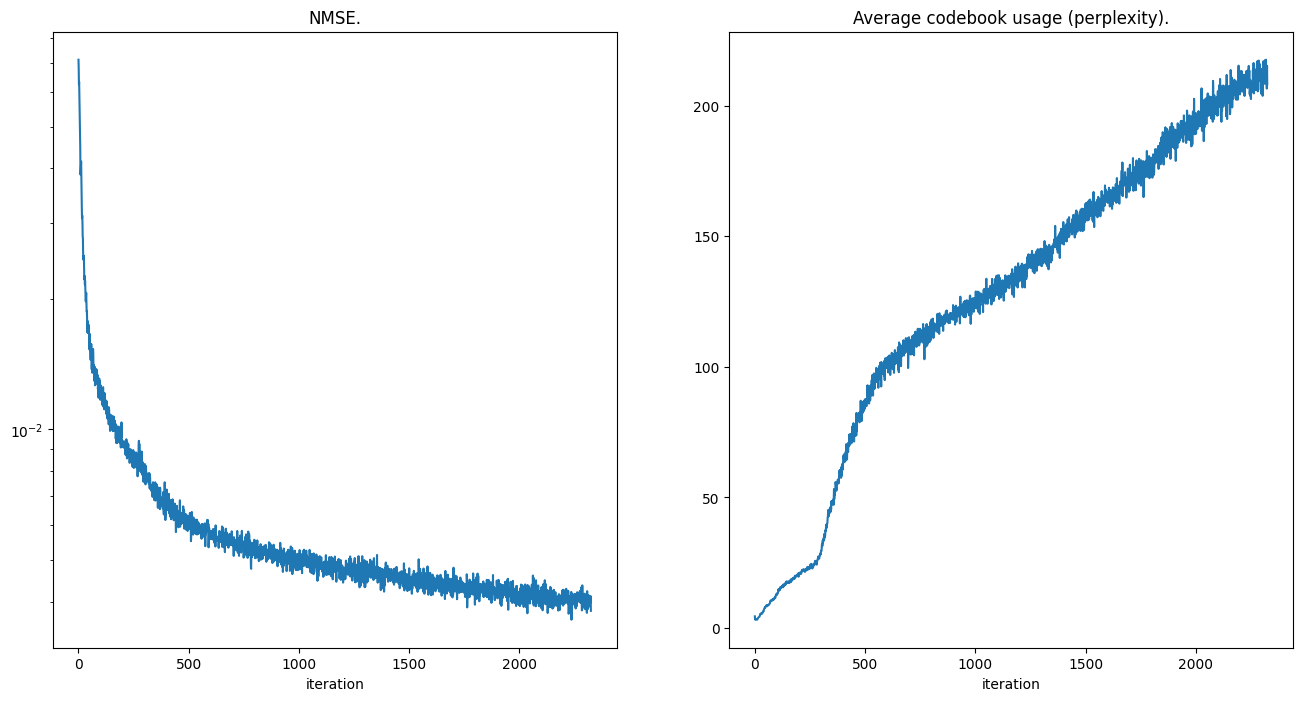

In [11]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

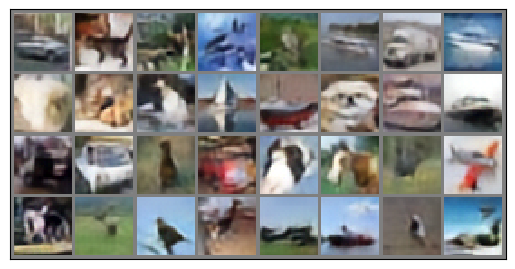

In [12]:
#@title View Reconstructions

model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model.encoder(valid_originals)
_, valid_quantize, _, _ = model.vq(vq_output_eval)
valid_reconstructions = model.decoder(valid_quantize)

(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model.vq(train_originals)


def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

show(make_grid(valid_reconstructions.cpu().data)+0.5, )

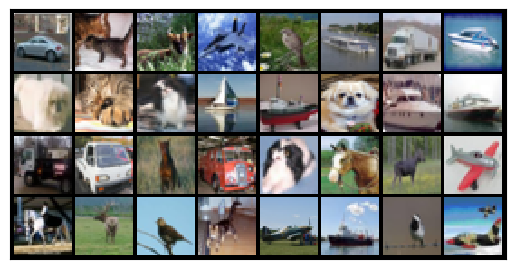

In [13]:
show(make_grid(valid_originals.cpu()+0.5))